## 0. Libarary 불러오기 및 경로설정

`!pip install -U albumentations==0.5.2`

`!pip install timm`

`!pip install facenet_pytorch`

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import time
import datetime
import albumentations
import timm
import wandb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
from copy import deepcopy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from pytz import timezone
from albumentations.pytorch.transforms import ToTensorV2
from facenet_pytorch import MTCNN

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler

# mtcnn 활용법 체크

```python
mtcnn = MTCNN(keep_all=True, device=cfg.device)

idx = np.random.randint(0, 18900 / 7, 1)[0]
img_path = glob.glob(cfg.img_dir + '/*/incorrect_*')[idx]
img = np.array(Image.open(img_path))
boxes, probs = mtcnn.detect(img)
if isinstance(boxes, np.ndarray):
    xmin = np.clip(int(boxes[0, 0]) - 50, 0, img.shape[0])
    ymin = np.clip(int(boxes[0, 1]) - 50, 0, img.shape[1])
    xmax = np.clip(int(boxes[0, 2]) + 50, 0, img.shape[0])
    ymax = np.clip(int(boxes[0, 3]) + 50, 0, img.shape[1])

    xmin, ymin, xmax, ymax
    img = img[ymin:ymax, xmin:xmax, :]
else:
    # 직접 crop
    img = img[100:400, 50:350, :]
print(img.shape, probs)
plt.imshow(img)
plt.show()

xmin = np.clip(int(boxes[0, 0]) - 30, 0, img.shape[0])
ymin = np.clip(int(boxes[0, 1]) - 30, 0, img.shape[1])
xmax = np.clip(int(boxes[0, 2]) + 30, 0, img.shape[0])
ymax = np.clip(int(boxes[0, 3]) + 30, 0, img.shape[1])

xmin, ymin, xmax, ymax
img = img[ymin:ymax, xmin:xmax, :]
plt.imshow(img)
plt.show()
```

## Config 정의

In [62]:
config = {
    'train_dir': '/opt/ml/input/data/train',
    'df_path': '/opt/ml/input/data/train/train_with_label.csv',
    'model_save_path': '/opt/ml/code/model',
    'submission_save_path': '/opt/ml/code/submission',
    'test_dir': '/opt/ml/input/data/eval',
    'submission_dir': '/opt/ml/code/submission/{}'.format(
        datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d")),
    'random_seed': 911203,
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'class_num': 18,
    'image_size': 224,
    'num_workers': 4,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    'model_name': 'efficientnet_b4',
}

In [63]:
# 부를 수 있는 모델 확인
all_models = timm.list_models('*efficient*')
all_models

['eca_efficientnet_b0',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_s',
 'gc_efficientnet_b0',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficientnet_b2_ap',
 'tf_efficien

## RANDOM SEED 고정

In [64]:
def set_seed(SEED):
    # Set random seed
    # random.seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

## Pretrained Model Class 정의

In [65]:
class ImgClassifier(nn.Module):
    def __init__(self, model_name, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Fine Tuning & Feature extractor 설정 함수 정의

In [66]:
def set_model_train_mode(model, mode=0):
    # Fine Tuning
    if mode == 0:
        for param in model.parameters():
            param.requires_grad = True
    # Feature extractor
    elif mode == 1:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        raise Exception('mode를 0: Fine Tuning 1: Feature extractor 를 위한 parameter를 넣으세요!')

In [67]:
def my_make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

In [68]:
# 데이터 Augmentation 을 위한 transform 정의 (albumentations 사용)
transforms_dict = {
    'train': albumentations.Compose([
        albumentations.Resize(config['image_size'], config['image_size'], p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ShiftScaleRotate(rotate_limit=30, p=0.5),
        albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        albumentations.GaussNoise(p=0.5),
        albumentations.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ]),
    'valid': albumentations.Compose([
        albumentations.Resize(config['image_size'], config['image_size'], p=1.0),
        albumentations.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ]),
    'test': albumentations.Compose([
        albumentations.Resize(config['image_size'], config['image_size'], p=1.0),
        albumentations.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ]),
}

## Dataset Class 정의

In [69]:
class MaskDataset(Dataset):
    def __init__(self, df, transform, mtcnn):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']
        self.mtcnn = mtcnn

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths.iloc[idx]))
#         image = self.face_crop(image)
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image, torch.tensor(label)
    
    def face_crop(self, img):
        boxes, probs = self.mtcnn.detect(img)
        if isinstance(boxes, np.ndarray):
            xmin = np.clip(int(boxes[0, 0]) - 50, 0, img.shape[0])
            ymin = np.clip(int(boxes[0, 1]) - 50, 0, img.shape[1])
            xmax = np.clip(int(boxes[0, 2]) + 50, 0, img.shape[0])
            ymax = np.clip(int(boxes[0, 3]) + 50, 0, img.shape[1])

            xmin, ymin, xmax, ymax
            img = img[ymin:ymax, xmin:xmax, :]
        else:
            # 직접 crop
            img = img[100:400, 50:350, :]
        return img

## EarlyStopping Class 정의

In [70]:
class EarlyStoppingF1:
    """Early stops the training if validation f1-score doesn't improve after a given patience."""
    def __init__(self, config, patience=5, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation f1-score improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation f1-score improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_min = 0.0
        self.config = config

    def __call__(self, val_f1, model):

        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model)
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        '''Saves model when validation f1-score increase.'''
        if self.verbose:
            print(f'Validation f1-score increased ({self.val_f1_min:.6f} --> {val_f1:.6f}).  Saving model ...')
        path = '{}'.format(os.path.join(self.config['model_save_path'], self.config['model_name']))
        my_make_dir(path)
        torch.save(model.state_dict(), '{}/checkpoint.pt'.format(path))
        self.val_f1_min = val_f1

In [73]:
def train_model(config):
    start = time.time()
    
    df = pd.read_csv(config['df_path'])

    # 5개의 KFold
    folds = StratifiedKFold(n_splits=5, 
                            shuffle=True, 
                            random_state=config['random_seed'])
    folds = folds.split(np.arange(len(df)), df['target'].values)

    train_idx, valid_idx = next(iter(folds))

    print(len(train_idx), len(valid_idx))
    
    model = ImgClassifier(model_name=config['model_name'], n_class=config['class_num'], pretrained=True)
    set_model_train_mode(model, 0)  # fine-tuning 방법 사용
    model = model.to(config['device'])

    mtcnn = MTCNN(keep_all=True, device=config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    earlystop = EarlyStoppingF1(config, patience=3, verbose=True)
    
    df_dict = {
        'train': df.iloc[train_idx].reset_index(drop=True),
        'valid': df.iloc[valid_idx].reset_index(drop=True),
    }

    datasets_dict = {
        tv: MaskDataset(df_dict[tv], transforms_dict[tv], mtcnn)
        for tv in ['train', 'valid']
    }

    dataloader_dict = {
        tv: torch.utils.data.DataLoader(
            datasets_dict[tv],
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers'],
        )
        for tv in ['train', 'valid']
    }

    dataset_sizes = {
        tv: len(datasets_dict[tv]) 
        for tv in ['train', 'valid']
    }
    
    best_f1 = 0.0
    
#     wandb.init(project='mask-image-classification', entity='raki-1203')
    
    for epoch in range(1, config['epochs'] + 1):
        print(f'Epoch {epoch:02}/{config["epochs"]}')
        print('*' * 10)
        
        # 각 에폭(epoch)은 학습 단계와 검증 단계를 가짐
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()  # 모델을 평가 모드로 설정
                
            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0.0
            
            # 데이터를 반복
            pbar = tqdm(dataloader_dict[phase], total=len(dataloader_dict[phase]))
            for inputs, labels in dataloader_dict[phase]:
                pbar.set_description(f'''
                    Epoch {epoch} | loss : {running_loss:.4f} | 
                    correct : {running_corrects :05} / {dataset_sizes[phase]} | F1_score : {running_f1:.4f}
                ''')
                inputs = inputs.to(config['device'])
                labels = labels.to(config['device'])
                
                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()
                
                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=-1)
                    loss = criterion(outputs, labels)
                    
                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_f1 += f1_score(preds.cpu().numpy(), 
                                       labels.cpu().numpy(), average='macro') * inputs.size(0)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = running_f1 / dataset_sizes[phase]
            
            print(f'{phase} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | F1-score: {epoch_f1:.4f}')

            # Best f1-score 저장 및 early stopping 에서 모델 저장
            if phase == 'valid':
                if best_f1 < epoch_f1:
                    best_f1 = epoch_f1
                
                earlystop(epoch_f1, model)
                
                if earlystop.early_stop:
                    print('Early stopping')
                    break
                    
        print()
        
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation F1-score: {:.4f}'.format(best_f1))
    
    model.load_state_dict(torch.load('{}/checkpoint.pt').format(
                        os.path.join(config['model_path'], config['model_name'])))
    
    return model

In [74]:
model = train_model(config)

15120 3780







Epoch 01/20
**********


train | Loss: 1.0173 | Acc: 0.7032 | F1-score: 0.5271


valid | Loss: 0.3043 | Acc: 0.8921 | F1-score: 0.7785
Validation f1-score increased (0.000000 --> 0.778511).  Saving model ...

Epoch 02/20
**********


train | Loss: 0.2915 | Acc: 0.8967 | F1-score: 0.7917


valid | Loss: 0.1821 | Acc: 0.9302 | F1-score: 0.8486
Validation f1-score increased (0.778511 --> 0.848558).  Saving model ...



Epoch 03/20
**********


train | Loss: 0.1783 | Acc: 0.9370 | F1-score: 0.8694


valid | Loss: 0.1308 | Acc: 0.9519 | F1-score: 0.8905
Validation f1-score increased (0.848558 --> 0.890470).  Saving model ...

Epoch 04/20
**********


train | Loss: 0.1141 | Acc: 0.9607 | F1-score: 0.9199


valid | Loss: 0.0873 | Acc: 0.9667 | F1-score: 0.9170
Validation f1-score increased (0.890470 --> 0.916981).  Saving model ...

Epoch 05/20
**********






















train | Loss: 0.0725 | Acc: 0.9744 | F1-score: 0.9431


valid | Loss: 0.0690 | Acc: 0.9746 | F1-score: 0.9224
Validation f1-score increased (0.916981 --> 0.922417).  Saving model ...

Epoch 06/20
**********


train | Loss: 0.0506 | Acc: 0.9839 | F1-score: 0.9668


valid | Loss: 0.0600 | Acc: 0.9786 | F1-score: 0.9425
Validation f1-score increased (0.922417 --> 0.942462).  Saving model ...

Epoch 07/20
**********


train | Loss: 0.0395 | Acc: 0.9876 | F1-score: 0.9727


valid | Loss: 0.0574 | Acc: 0.9794 | F1-score: 0.9437
Validation f1-score increased (0.942462 --> 0.943663).  Saving model ...





Epoch 08/20
**********


train | Loss: 0.0384 | Acc: 0.9882 | F1-score: 0.9763


valid | Loss: 0.0535 | Acc: 0.9807 | F1-score: 0.9525
Validation f1-score increased (0.943663 --> 0.952491).  Saving model ...

Epoch 09/20
**********


train | Loss: 0.0361 | Acc: 0.9892 | F1-score: 0.9762


valid | Loss: 0.0528 | Acc: 0.9807 | F1-score: 0.9488
EarlyStopping counter: 1 out of 3

Epoch 10/20
**********







train | Loss: 0.0346 | Acc: 0.9893 | F1-score: 0.9800


valid | Loss: 0.0537 | Acc: 0.9810 | F1-score: 0.9532
Validation f1-score increased (0.952491 --> 0.953247).  Saving model ...





Epoch 11/20
**********


train | Loss: 0.0318 | Acc: 0.9898 | F1-score: 0.9776


valid | Loss: 0.0520 | Acc: 0.9812 | F1-score: 0.9443
EarlyStopping counter: 1 out of 3

Epoch 12/20
**********







train | Loss: 0.0304 | Acc: 0.9905 | F1-score: 0.9798


valid | Loss: 0.0518 | Acc: 0.9807 | F1-score: 0.9511
EarlyStopping counter: 2 out of 3

Epoch 13/20
**********







train | Loss: 0.0311 | Acc: 0.9914 | F1-score: 0.9831


valid | Loss: 0.0521 | Acc: 0.9810 | F1-score: 0.9545
Validation f1-score increased (0.953247 --> 0.954478).  Saving model ...

Epoch 14/20
**********


train | Loss: 0.0321 | Acc: 0.9903 | F1-score: 0.9787


valid | Loss: 0.0505 | Acc: 0.9841 | F1-score: 0.9618
Validation f1-score increased (0.954478 --> 0.961759).  Saving model ...






Epoch 15/20
**********


train | Loss: 0.0315 | Acc: 0.9901 | F1-score: 0.9782


valid | Loss: 0.0507 | Acc: 0.9804 | F1-score: 0.9537
EarlyStopping counter: 1 out of 3

Epoch 16/20
**********







train | Loss: 0.0299 | Acc: 0.9917 | F1-score: 0.9838


valid | Loss: 0.0496 | Acc: 0.9820 | F1-score: 0.9578
EarlyStopping counter: 2 out of 3

Epoch 17/20
**********







train | Loss: 0.0313 | Acc: 0.9911 | F1-score: 0.9822


valid | Loss: 0.0501 | Acc: 0.9825 | F1-score: 0.9548
EarlyStopping counter: 3 out of 3
Early stopping

Epoch 18/20
**********







train | Loss: 0.0332 | Acc: 0.9902 | F1-score: 0.9795


valid | Loss: 0.0510 | Acc: 0.9802 | F1-score: 0.9475
EarlyStopping counter: 4 out of 3
Early stopping

Epoch 19/20
**********







train | Loss: 0.0276 | Acc: 0.9918 | F1-score: 0.9835


valid | Loss: 0.0516 | Acc: 0.9820 | F1-score: 0.9552
EarlyStopping counter: 5 out of 3
Early stopping

Epoch 20/20
**********







train | Loss: 0.0292 | Acc: 0.9912 | F1-score: 0.9832


valid | Loss: 0.0492 | Acc: 0.9823 | F1-score: 0.9554
EarlyStopping counter: 6 out of 3
Early stopping

Training complete in 34m 50s
Best validation F1-score: 0.9618


FileNotFoundError: [Errno 2] No such file or directory: '{}/checkpoint.pt'

## 학습 그래프 표출 함수 정의

## Inference 과정

In [25]:
# sumission_dir 생성
my_make_dir(cfg.submission_dir)

## 6.1 Test Dataset 정의

In [26]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = np.array(Image.open(self.img_paths[index]))

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [27]:
sorted(glob.glob(os.path.join(cfg.model_save_path, cfg.model_name) + '_*/checkpoint.pt'))

['/opt/ml/code/model/efficientnet_b3_1/checkpoint.pt']

In [28]:
test_transform = albumentations.Compose([
    albumentations.CenterCrop(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, p=1.0),
    albumentations.Normalize(cfg.mean_list, cfg.std_list, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0),
])

In [29]:
# 테스트셋 추론 메인 코드

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(cfg.test_dir, 'info.csv'))
image_dir = os.path.join(cfg.test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, test_transform)

loader = DataLoader(
    dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=cfg.NUM_WORKERS,
)

# KFOLD를 이용한 모델 5개의 checkpoint.pt path
checkpoint_path_list = sorted(glob.glob(os.path.join(cfg.model_save_path, 
                                                     cfg.model_name) + '_*/checkpoint.pt'))
for i, checkpoint_path in enumerate(checkpoint_path_list):
    # 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
    model = ImgClassifier(model_name=cfg.model_name, 
                          n_class=cfg.CLASS_NUM, 
                          pretrained=False).to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
    all_predictions = []
    for images in tqdm(loader):
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    # 제출할 파일을 저장합니다.
    submission.to_csv(os.path.join(cfg.submission_dir, 'submission_{}.csv'.format(
        checkpoint_path.split('/')[-2])), index=False)
    
    print(f'{i + 1} 번째 sumission file 생성!')
print('test inference is done!')


1 번째 sumission file 생성!
test inference is done!


In [25]:
submission_file_list = glob.glob(os.path.join(cfg.submission_dir, 
                                             'submission_{}_*'.format(cfg.model_name)))

In [26]:
submission_file_list

['/opt/ml/code/submission/2021-08-26/submission_tf_efficientnet_b4_ns_1 (78.143_0.729).csv',
 '/opt/ml/code/submission/2021-08-26/submission_tf_efficientnet_b4_ns_1.csv']

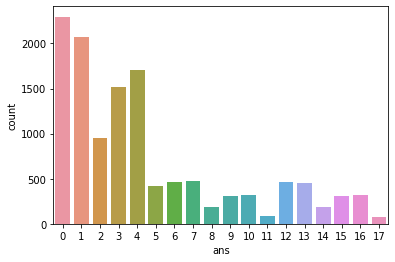

In [27]:
import seaborn as sns
result_df = pd.read_csv(submission_file_list[0])
sns.countplot(result_df['ans'])

In [36]:
for i, file in enumerate(submission_file_list):
    if i == 0:
        result_df = pd.read_csv(file)
        result_df.rename({'ans': 'ans_1'}, axis=1, inplace=True)
    else:
        temp_df = pd.read_csv(file)
        result_df['ans_{}'.format(i + 1)] = temp_df['ans']
        
result_df['ans'] = result_df.apply(lambda x: x.iloc[1:].value_counts().index[0], axis=1)
result_df.drop(['ans_{}'.format(i) for i in range(1, 6)], axis=1, inplace=True)
result_df.to_csv(os.path.join(cfg.submission_dir, 
                              'submission_{}_ensemble.csv'.format(cfg.model_name)),
                 index=False)

KeyError: "['ans_2' 'ans_3' 'ans_4' 'ans_5'] not found in axis"